In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from scipy.signal import savgol_filter
from scipy.stats import norm

In [2]:
os.system("wget https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip")
os.system("unzip datos_abiertos_covid19.zip")
os.system("rm datos_abiertos_covid19.zip")

file = (pd.to_datetime('today') - pd.Timedelta('1 days')).strftime('%y%m%d')+"COVID19MEXICO.csv" #Database file
Lag = 70#10 weeks into the past
Date_Range = pd.date_range(end=pd.to_datetime('today').date(), periods=Lag)

df = pd.read_csv(file, engine="python")



--2022-04-19 03:18:09--  https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip
Resolving datosabiertos.salud.gob.mx (datosabiertos.salud.gob.mx)... 187.210.186.146
Connecting to datosabiertos.salud.gob.mx (datosabiertos.salud.gob.mx)|187.210.186.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304232743 (290M) [application/x-zip-compressed]
Saving to: ‘datos_abiertos_covid19.zip’

     0K .......... .......... .......... .......... ..........  0% 1.51M 3m13s
    50K .......... .......... .......... .......... ..........  0% 11.4M 1m49s
   100K .......... .......... .......... .......... ..........  0% 2.37M 1m53s
   150K .......... .......... .......... .......... ..........  0% 3.09M 1m49s
   200K .......... .......... .......... .......... ..........  0% 11.5M 92s
   250K .......... .......... .......... .......... ..........  0% 3.56M 90s
   300K .......... .......... .......... .......... ..........  0% 11.3M 81s
   35

Archive:  datos_abiertos_covid19.zip
  inflating: 220418COVID19MEXICO.csv  


ValueError: list.remove(x): x not in list

In [3]:
columns = list(df.columns)
columns.remove('ENTIDAD_RES')
columns.remove('FECHA_SINTOMAS')
columns.remove('FECHA_INGRESO')
columns.remove('CLASIFICACION_FINAL')
df = df.drop(columns=columns)
df = df.drop(df[pd.to_datetime(df.FECHA_SINTOMAS) < Date_Range[0]].index)
df = df.drop(df[df.CLASIFICACION_FINAL > 3].index)
df = df.drop(columns=['CLASIFICACION_FINAL'])

In [93]:
df_Entities = pd.read_csv("../Data/Entidades.csv")

df_Incidence = pd.DataFrame({'Date':Date_Range})
for entity in range(33):
    Incidence = []
    for date in range(Lag):
        Incidence.append(count_incidence(df, str(Date_Range[date].date()), entity) )
    df_Incidence[df_Entities.iloc[entity, 0]] = Incidence

df_Incidence.to_csv("../Data/Incidence.csv", index=False)

In [291]:
loc = (pd.to_datetime(df['FECHA_INGRESO'])-pd.to_datetime(df['FECHA_SINTOMAS'])).mean().total_seconds()/3600/24 + 3
scale = (pd.to_datetime(df['FECHA_INGRESO'])-pd.to_datetime(df['FECHA_SINTOMAS'])).std().total_seconds()/3600/24

Entities = list(df_Entities.Entidad)
trst = 15

df_Nowcasting = pd.DataFrame()
df_Nowcasting["Date"] = df_Incidence["Date"]
for entity in Entities:
    aux = df_Incidence[entity].rolling(5, center=True).mean()
    aux[[0, 1, Lag-2, Lag-1]] = df_Incidence[entity][[0, 1, Lag-2, Lag-1]]
    model_fit = AutoReg(aux[:-trst], lags=7, trend='t', seasonal=True, period= 7).fit()
    df_Nowcasting[entity] = aux
    prediction = model_fit.predict(start=Lag-trst, end=Lag-1)
    for i in range(Lag-trst, Lag):
        df_Nowcasting.at[i, entity] = max(prediction.at[i], df_Nowcasting.at[i, entity])

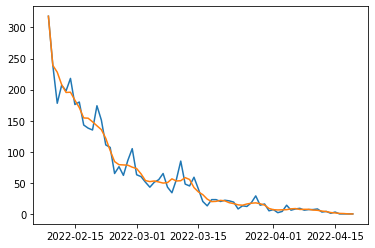

In [300]:
entity = "Querétaro"
plt.plot(df_Incidence["Date"][0:], df_Incidence[entity][0:])
plt.plot(df_Nowcasting["Date"][0:], df_Nowcasting[entity][0:])



<AxesSubplot:xlabel='Entidad'>

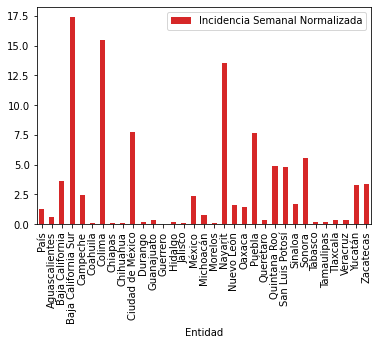

In [318]:
Incidences = []
Rates = []
for entity in Entities:
    Incidences.append(df_Nowcasting[entity][Lag-7:].sum())
    Rates.append(df_Nowcasting[entity][Lag-7:].sum() / df_Nowcasting[entity][Lag-14:Lag-7].sum() - 1)
df_Entities["Incidencia Semanal"] = Incidences
df_Entities['Tasa de Cambio'] = Rates



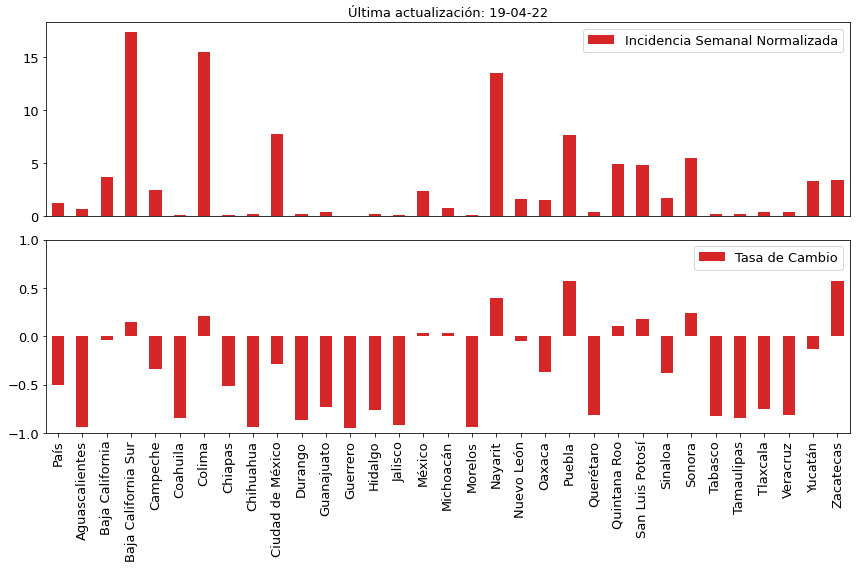

In [319]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
df_Entities.plot.bar(x='Entidad', y='Incidencia Semanal Normalizada', color='C3', ax=axs[0])
axs[0].set_title('Última actualización: '+pd.to_datetime('today').strftime('%d-%m-%y'), fontsize=13)
axs[0].set_xlabel('')
axs[0].set_xticks([])
axs[0].yaxis.set_tick_params(labelsize=13)
axs[0].legend(fontsize=13)
df_Entities.plot.bar(x='Entidad', y='Tasa de Cambio', color='C3', ax=axs[1])
axs[1].set_ylim([-1, 1])
axs[1].set_xlabel('')
axs[1].xaxis.set_tick_params(labelsize=13)
axs[1].yaxis.set_tick_params(labelsize=13)
axs[1].legend(fontsize=13)
fig.tight_layout()
#fig.savefig('../docs/Fig01.png')



In [322]:
import plotly.express as px
from plotly.subplots import make_subplots


fig1 = px.bar(df_Entities, x='Entidad', y='Incidencia Semanal Normalizada')
fig2 = px.bar(df_Entities, x='Entidad', y='Tasa de Cambio')

fig = make_subplots(rows=2, cols=1)
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=2, col=1)
fig.update_layout(title_text="Útlima actialización: "+pd.to_datetime('today') .strftime('%d-%m-%y'),
    height=600
    )
fig.update_xaxes(showticklabels=False, title=None, row=1, col=1)
fig.update_yaxes(title="Incidencia Semanal Normalizada", row=1, col=1)
fig.update_yaxes(title="Tasa de Cambio", row=2, col=1)

#fig.show()
fig.write_html("../docs/Fig01.html")
